In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
#symbols = ["Li", "H"]
electrons = 4
orbitals = 8

#symbols = ["Li", "H"]
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
#coordinates = np.array([[0.0,0.0, 0*r_bohr], [0.0, 0.0, 1*r_bohr]])
# Calculation of the Hamiltonian
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")

hf_state = qchem.hf_state(electrons, qubits)
#Calculation of HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def circuit(hf_state, electrons, qubits, H):
    # Prepare the Hartree-Fock state
    print('Updated hf_state is', hf_state)  
    qml.BasisState(hf_state, wires=range(qubits))
    return qml.expval(H)   #Calculating the expectation value of the Hamiltonian

# Commutator calculation for HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
    qml.BasisState(k, wires=range(qubits))
    res = qml.commutator(H, w)   #Calculating the commutator
    return qml.expval(res)

# Commutator calculation for other states except HF state
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
    qml.StatePrep(k, wires=range(qubits))
    res = qml.commutator(H, w) #Calculating the commutator
    return qml.expval(res)

# Energy calculation 
dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def ash(params, ash_excitation, hf_state, qubits, H):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
    for i, excitation in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])
        elif len(ash_excitation[i]) == 2:
            #print('Single Exc going in is', ash_excitation[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.expval(H)  #Calculating the expectation value of the Hamiltonian

# Calculation of New state, same as the above function but with the state return

dev = qml.device("lightning.qubit", wires=qubits)
@qml.qnode(dev)
def new_state(hf_state, ash_excitation, params):
    #qml.BasisState(hf_state, wires=range(qubits))
    [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
    for i, excitations in enumerate(ash_excitation):
        if len(ash_excitation[i]) == 4:
            print('Exc. dealing right now is', ash_excitation[i])
            print('The params that are going in', params[i])
            qml.FermionicDoubleExcitation(weight=params[i], wires1=ash_excitation[i][2:][::-1], wires2=ash_excitation[i][:2][::-1])

        elif len(ash_excitation[i]) == 2:
            print('Single Exc. dealing right now is', ash_excitation[i])
            print('Single exc params that are going in', params[i])
            qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))

    return qml.state()

def cost(params):
    energy = ash(params, ash_excitation, hf_state, qubits, H)
    return energy

def callback(params):
    print(f"Current parameters: {params}")
    print(f"Current cost: {cost(params)}\n")

def adaptvqe(H, hf_state, electrons, qubits,a_it=15):
    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]


    for j in range(a_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state

        for i in operator_pool:
            print('The current excitation operator is', i)   #Current excitation operator - fermionic one
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                print('Print, if this is activated - HF state')
                #current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated 
                current_value = abs(2 * (commutator_0(H, w, k).real))
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value

        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        print('The current status of ash_excitation is', ash_excitation)
        print('Moving towards parameters')
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
            print('Parameters are', params)
        else:
             params = np.append(params, 0.0) 
             print('Parameters before optimization are', params)


        #Energy calculation
        result = minimize(cost, params, method='L-BFGS-B', callback=callback, tol = 1e-16, options = {'disp': True, 'maxiter': 1e8, 'ftol': 1e-16, 
                                                                                                      'gtol':1e-16, 'maxls': 100})

        print("Final updated parameters:", result.x)
        print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        states.append(ostate)
        
    return energies, params, ash_excitation




In [2]:
adaptvqe(H, hf_state, electrons, qubits,a_it=21)

/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/pennylane/measurements/expval.py:72: UserWarning: Sum might not be hermitian.
  warnings.warn(f"{op.name} might not be hermitian.")
/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/pennylane_lightning/core/_serialize.py:250: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066892
The adapt iteration now is 0
The current excitation operator is a⁺(0) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(4) is 9.258137056294968e-08
The current excitation operator is a⁺(0) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(5) is 9.258137057335802e-08
The current excitation operator is a⁺(1) a(7)
Print, if this is activated - HF state
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
Print, if this is activated - HF state
The expectation value of a⁺(2) a(6) is 1.1698932345788338e-07
The current excitation operator is a⁺(3) a(5)
Print, if this is activated - HF 

 This problem is unconstrained.



At iterate    2    f= -1.42998D+00    |proj g|=  5.94067D-03
Current parameters: [-1.15754304]
Current cost: -1.429981032610625


At iterate    3    f= -1.43008D+00    |proj g|=  1.08136D-05
Current parameters: [-1.12293022]
Current cost: -1.4300836705047877


At iterate    4    f= -1.43008D+00    |proj g|=  1.77636D-07
Current parameters: [-1.12299311]
Current cost: -1.4300836708403017


At iterate    5    f= -1.43008D+00    |proj g|=  1.55431D-07
Current parameters: [-1.12299286]
Current cost: -1.4300836708403168

Current parameters: [-1.12299286]

At iterate    6    f= -1.43008D+00    |proj g|=  8.88178D-08
Current cost: -1.4300836708403173


At iterate    7    f= -1.43008D+00    |proj g|=  8.88178D-08
Current parameters: [-1.12299286]
Current cost: -1.4300836708403173

Final updated parameters: [-1.12299286]
Final cost: -1.4300836708403173
Updated params are [-1.12299286]
Updated excitation are [[2, 3, 6, 7]]
Exc. dealing right now is [2, 3, 6, 7]
The params that are going in -1.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(6) is 0.0
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.02037795485161899
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 0.0
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 0.0
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.06512012719455602
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 0.0
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 0.06512012719455601
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 0.30574752590553855
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The expectation value of a⁺(0) a⁺(1) a(4) a(7) is 0.0
The current excitation operator is a⁺(0) a⁺(1) a(5) a(6)
The expectation value of a⁺(0) a⁺(1) a(5) a(6) is 0.0
The current excitation ope

 This problem is unconstrained.


Current cost: -1.5578708504837455


At iterate    2    f= -1.56590D+00    |proj g|=  3.43129D-02
Current parameters: [-0.97945657 -1.50879427]
Current cost: -1.5658973801045235


At iterate    3    f= -1.56939D+00    |proj g|=  6.07765D-03
Current parameters: [-1.12056504 -1.38358679]
Current cost: -1.5693880164093064


At iterate    4    f= -1.56946D+00    |proj g|=  1.26787D-04
Current parameters: [-1.09769692 -1.37845714]
Current cost: -1.5694603147011508


At iterate    5    f= -1.56946D+00    |proj g|=  4.39648D-06
Current parameters: [-1.09716094 -1.37778292]
Current cost: -1.5694603835015961


At iterate    6    f= -1.56946D+00    |proj g|=  6.66134D-07
Current parameters: [-1.09716265 -1.37775477]
Current cost: -1.5694603835511014


At iterate    7    f= -1.56946D+00    |proj g|=  1.33227D-07
Current parameters: [-1.09716238 -1.37775846]
Current cost: -1.5694603835519527


At iterate    8    f= -1.56946D+00    |proj g|=  1.77636D-07
Current parameters: [-1.09716239 -1.37775846]


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 0.07214545531758776
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 2.827123476644464e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.03455226685466645
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 1.600968477053584e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 1.59129246833968e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.09009515528970582
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 2.5851722484046895e-17
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 0.08582057272996697
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 0.4247574320890529
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The expectation

 This problem is unconstrained.



At iterate    1    f= -1.72407D+00    |proj g|=  8.02543D-02
Current parameters: [-1.0971623  -1.37775781 -1.        ]
Current cost: -1.7240674243491128


At iterate    2    f= -1.73665D+00    |proj g|=  3.41378D-02
Current parameters: [-1.32368346 -1.27257246 -1.64720432]
Current cost: -1.7366529265249242


At iterate    3    f= -1.74353D+00    |proj g|=  7.03493D-03
Current parameters: [-1.18079676 -1.39290979 -1.46763521]
Current cost: -1.7435288963117073


At iterate    4    f= -1.74363D+00    |proj g|=  9.82037D-04
Current parameters: [-1.20651249 -1.38194071 -1.45528305]
Current cost: -1.743630959680403


At iterate    5    f= -1.74363D+00    |proj g|=  7.54952D-06
Current parameters: [-1.20342328 -1.38273906 -1.45823831]
Current cost: -1.743633442209473


At iterate    6    f= -1.74363D+00    |proj g|=  2.79776D-06
Current parameters: [-1.20340037 -1.38270993 -1.45819783]
Current cost: -1.7436334425918303


At iterate    7    f= -1.74363D+00    |proj g|=  5.10703D-07
Current pa


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(6) is 7.734242305566936e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.10813602342298399
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 7.460067256136261e-18
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 2.288658954998692e-18
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.11088879779121834
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 8.097208220978646e-17
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 0.10794557128307963
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 3.9727784062471017e-08
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The expectation value of a⁺(0) a⁺(1) a(4) a(7) is 2.4025057399979255e-18
The current excitation operator is a⁺(0) a⁺

 This problem is unconstrained.



At iterate    1    f= -1.78904D+00    |proj g|=  1.48330D-01
Current parameters: [-1.20339835 -1.38269884 -1.45819263 -1.        ]
Current cost: -1.7890358750967401


At iterate    2    f= -1.83317D+00    |proj g|=  5.56655D-02
Current parameters: [-0.9073952  -1.39437029 -1.23635237 -1.11822325]
Current cost: -1.8331703283753467


At iterate    3    f= -1.84080D+00    |proj g|=  2.43233D-02
Current parameters: [-0.75310352 -1.31914696 -1.02569474 -1.22313121]
Current cost: -1.8407989740886732


At iterate    4    f= -1.84193D+00    |proj g|=  6.86460D-03
Current parameters: [-0.81756177 -1.29300161 -1.03155045 -1.12770381]
Current cost: -1.8419253670639848


At iterate    5    f= -1.84211D+00    |proj g|=  1.02078D-03
Current parameters: [-0.82876104 -1.28826024 -1.01230887 -1.16335352]
Current cost: -1.8421080430437686


At iterate    6    f= -1.84211D+00    |proj g|=  7.47180D-05
Current parameters: [-0.8286444  -1.28786088 -1.00786161 -1.1638868 ]
Current cost: -1.8421101303697516

 This problem is unconstrained.


Current parameters: [-0.8288207  -1.28813221 -1.00807477 -1.16383456  0.27619246]
At iterate    1    f= -1.85042D+00    |proj g|=  2.03715D-03

Current cost: -1.8504242549915173


At iterate    2    f= -1.85043D+00    |proj g|=  2.27793D-03
Current parameters: [-0.83486394 -1.28987294 -1.01792389 -1.16703401  0.28147283]
Current cost: -1.850427709255217


At iterate    3    f= -1.85044D+00    |proj g|=  1.86406D-04
Current parameters: [-0.83079881 -1.28994107 -1.0146314  -1.16498033  0.28134496]
Current cost: -1.8504356978245937


At iterate    4    f= -1.85044D+00    |proj g|=  1.18727D-04
Current parameters: [-0.83041493 -1.29009823 -1.01511692 -1.16466004  0.2811995 ]
Current cost: -1.8504358645307777


At iterate    5    f= -1.85044D+00    |proj g|=  1.41442D-05
Current parameters: [-0.83018459 -1.29013705 -1.01579704 -1.16417333  0.28113604]
Current cost: -1.8504359354114024


At iterate    6    f= -1.85044D+00    |proj g|=  9.99201D-07
Current parameters: [-0.83023383 -1.29014481


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 2.0119291122867866e-07
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 4.147140944468138e-18
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.0029114848470105804
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 1.5828151573740047e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 1.2641044994992197e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.11942151497724471
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 6.033643323746329e-18
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 0.12345363819351199
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 0.00019328363820680927
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The 

 This problem is unconstrained.



At iterate    1    f= -1.85944D+00    |proj g|=  2.61398D-03
Current parameters: [-0.83023677 -1.29014734 -1.01581287 -1.16408899  0.28113995  0.28539842]
Current cost: -1.8594367621168002


At iterate    2    f= -1.85945D+00    |proj g|=  1.98017D-03
Current parameters: [-0.83866566 -1.29095875 -1.01781614 -1.1668335   0.29359866  0.29100323]
Current cost: -1.8594541172608046

Current parameters: [-0.83450448 -1.29177794 -1.01560233 -1.16509434  0.29366975  0.29120103]
At iterate    3    f= -1.85946D+00    |proj g|=  1.04983D-04

Current cost: -1.8594599838465469


At iterate    4    f= -1.85946D+00    |proj g|=  1.67422D-05
Current parameters: [-0.83464855 -1.29164862 -1.01570861 -1.16516974  0.2935544   0.29071053]
Current cost: -1.8594600243746835


At iterate    5    f= -1.85946D+00    |proj g|=  1.68754D-06
Current parameters: [-0.83463688 -1.29159226 -1.01570609 -1.16517484  0.2935734   0.29070936]
Current cost: -1.8594600249985458


At iterate    6    f= -1.85946D+00    |proj 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 6.717920246479547e-08
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 9.029338576632467e-18
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.007363732075264287
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 3.226605527839576e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 1.7827612367306083e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.00742032000688881
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 6.558294588782801e-19
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 3.910475376497913e-08
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 0.00019534818041780366
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The e

 This problem is unconstrained.



At iterate    1    f= -1.85949D+00    |proj g|=  3.61406D-03
Current parameters: [-0.83463182 -1.29158691 -1.01570696 -1.16518676  0.29357652  0.29070988
 -0.01640962]
Current cost: -1.8594918951554102


At iterate    2    f= -1.86292D+00    |proj g|=  2.29859D-02
Current parameters: [-0.82129408 -1.27844456 -1.01390744 -1.15796934  0.28925463  1.02191789
 -0.83298697]
Current cost: -1.862922533222125


At iterate    3    f= -1.86331D+00    |proj g|=  2.48622D-02
Current parameters: [-0.81860993 -1.27611267 -1.01343958 -1.15670879  0.28865915  1.16295601
 -0.98600768]
Current cost: -1.8633143854333267


At iterate    4    f= -1.86403D+00    |proj g|=  2.52639D-02
Current parameters: [-0.79679896 -1.30806484 -0.99462604 -1.17544158  0.3066405   1.39722419
 -1.22891009]
Current cost: -1.8640304914375614


At iterate    5    f= -1.86491D+00    |proj g|=  1.49239D-02
Current parameters: [-0.83658279 -1.31548507 -0.99630985 -1.21654933  0.31369732  1.63212003
 -1.41449759]
Current cost: -1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 1.4140438217222218e-07
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 4.3241229204591814e-18
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.029467379554196062
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 3.043199680139323e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 3.527793718010133e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 6.24433529198068e-08
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 8.247542344360531e-18
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 1.6107633282747003e-08
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 0.001333742348363337
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.86568D+00    |proj g|=  1.67728D-02
Current parameters: [-0.82155158 -1.33468244 -0.97673126 -1.20925171  0.31947229  1.56466107
 -1.28282651  0.07518749]
At iterate    1    f= -1.86633D+00    |proj g|=  2.87743D-03

Current cost: -1.866332128718392

Current parameters: [-0.83494698 -1.33908701 -0.97243096 -1.21177639  0.31925832  1.56474083
 -1.28627768  0.08134572]
At iterate    2    f= -1.86636D+00    |proj g|=  1.47748D-03

Current cost: -1.8663617254314515

Current parameters: [-0.83793557 -1.3465296  -0.96596209 -1.21169299  0.31946196  1.56755556
 -1.28751994  0.08371843]
At iterate    3    f= -1.86637D+00    |proj g|=  3.58802D-04

Current cost: -1.8663720465029203

Current parameters: [-0.8380873  -1.34815078 -0.96577681 -1.21330335  0.31904955  1.56943448
 -1.28923153  0.08299955]

At i

 This problem is unconstrained.


Current parameters: [-0.83653256 -1.34797243 -0.96558881 -1.21433887  0.31907522  1.61056405
 -1.33058716  0.08360838 -0.06507178]
At iterate    1    f= -1.86688D+00    |proj g|=  1.42373D-02

Current cost: -1.8668823400202763

Current parameters: [-0.87131778 -1.31073136 -0.98675042 -1.19623455  1.02904374  1.64972341
 -1.29368307  0.08058097 -0.86466047]
At iterate    2    f= -1.87697D+00    |proj g|=  3.35154D-02

Current cost: -1.8769713928091727

Current parameters: [-0.87542911 -1.29519233 -0.99617966 -1.18133382  1.39286371  1.6538273
 -1.29194957  0.07829667 -1.24011961]
At iterate    3    f= -1.88007D+00    |proj g|=  3.23345D-02

Current cost: -1.8800719548360934

Current parameters: [-0.82917048 -1.31561047 -0.98842334 -1.18217664  1.45796155  1.64196537
 -1.31127754  0.07371919 -1.3097419 ]
At iterate    4    f= -1.88092D+00    |proj g|=  3.31301D-02

Current cost: -1.8809240854887141

Current parameters: [-0.83263699 -1.30340602 -1.00000321 -1.17938327  1.67055216  1.63301

 This problem is unconstrained.



At iterate    1    f= -1.88436D+00    |proj g|=  3.55183D-04
Current parameters: [-0.56603802 -0.64696992 -0.59227199 -0.62032361  1.63551162  1.70625918
 -1.42428667  0.07459865 -1.34992965  0.00324638]
Current cost: -1.8843572990802242


At iterate    2    f= -1.88436D+00    |proj g|=  5.00178D-04
Current parameters: [-0.56624226 -0.64690221 -0.59379488 -0.62037193  1.6407149   1.70587148
 -1.42391001  0.07539258 -1.35567402  0.0095375 ]
Current cost: -1.884360832627465


At iterate    3    f= -1.88438D+00    |proj g|=  7.15317D-04
Current parameters: [-0.56629381 -0.64924951 -0.59874063 -0.62247106  1.67373059  1.70509009
 -1.42305922  0.0771647  -1.38916502  0.04405518]
Current cost: -1.8843751193229663


At iterate    4    f= -1.88438D+00    |proj g|=  9.90363D-04
Current parameters: [-0.57023058 -0.64952297 -0.5999598  -0.6235235   1.69141598  1.70585767
 -1.42412853  0.07544314 -1.40709297  0.06134699]
Current cost: -1.8843799595016582

Current parameters: [-0.56994087 -0.65263


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 1.56427899036804e-08
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 1.3902506981378534e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 1.2970709222653865e-07
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 2.4344384379979883e-19
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 1.2967050835694133e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 9.702214845419554e-08
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 2.048737120402107e-18
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 2.9263135799956208e-08
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 8.890018815543854e-08
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)


 This problem is unconstrained.



At iterate    1    f= -1.88444D+00    |proj g|=  8.43769D-07
Current parameters: [-8.43150028e-01 -1.36688004e+00 -1.04871068e+00 -1.22808501e+00
  1.71345260e+00  1.71178478e+00 -1.42981114e+00  8.01160284e-02
 -1.42814592e+00  7.81236731e-02 -1.68604313e-04]
Current cost: -1.8844361670837033


At iterate    2    f= -1.88444D+00    |proj g|=  2.66454D-07
Current parameters: [-8.43149711e-01 -1.36687909e+00 -1.04871057e+00 -1.22808575e+00
  1.71345186e+00  1.71178320e+00 -1.42981261e+00  8.01162919e-02
 -1.42814666e+00  7.81245181e-02 -1.70717499e-04]
Current cost: -1.8844361670852914


At iterate    3    f= -1.88444D+00    |proj g|=  2.88658D-07
Current parameters: [-8.43150152e-01 -1.36687916e+00 -1.04871097e+00 -1.22808615e+00
  1.71345235e+00  1.71178360e+00 -1.42981242e+00  8.01165918e-02
 -1.42814612e+00  7.81250510e-02 -1.72989600e-04]
Current cost: -1.88443616708584


At iterate    4    f= -1.88444D+00    |proj g|=  4.21885D-07
Current parameters: [-8.43150236e-01 -1.36687969e


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 1.5091161349040094e-07
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 5.441311889722675e-18
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 2.1751269188574618e-09
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 1.8262384567416233e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 9.087011880865009e-19
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 1.741329543891723e-07
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 9.865551169731659e-18
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 2.559330735153742e-07
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 1.5776550917057097e-07
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88444D+00    |proj g|=  3.97904D-05

At iterate    1    f= -1.88444D+00    |proj g|=  3.85247D-05
Current parameters: [-8.43148429e-01 -1.36688320e+00 -1.04871243e+00 -1.22808844e+00
  1.71345043e+00  1.71178233e+00 -1.42981253e+00  8.01144614e-02
 -1.42814623e+00  7.81276780e-02 -1.73849554e-04 -3.35697746e-04]
Current cost: -1.884436173969009

Current parameters: [-0.84317783 -1.36691852 -1.04870813 -1.22815937  1.71345892  1.71177198
 -1.42979575  0.08017943 -1.42811067  0.07810238 -0.00380716 -0.00416769]
At iterate    2    f= -1.88444D+00    |proj g|=  5.40012D-05

Current cost: -1.8844362952014593


At iterate    3    f= -1.88444D+00    |proj g|=  1.24478D-04
Current parameters: [-0.84287458 -1.36711487 -1.04865587 -1.22811275  1.71333166  1.71172831
 -1.42982023  0.0800882  -1.42821645  0.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Exc. dealing right now is [2, 3, 6, 7]
The params that are going in -0.843068486439092
Exc. dealing right now is [0, 3, 5, 6]
The params that are going in -1.3671034372719015
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in -1.0486942023716552
Exc. dealing right now is [1, 2, 4, 7]
The params that are going in -1.2283052881789356
Single Exc. dealing right now is [0, 4]
Single exc params that are going in 1.7134507060826585
Single Exc. dealing right now is [3, 7]
Single exc params that are going in 1.711782408239862
Single Exc. dealing right now is [2, 6]
Single exc params that are going in -1.4298136629124143
Exc. dealing right now is [2, 3, 6, 7]
The params that are going in 0.08017097780314743
Single Exc. dealing right now is [1, 5]
Single exc params that are going in -1.428146664945592
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in 0.07817962899746116
Exc. dealing right now is [0, 1, 6, 7]
The params that are going in -0.01421361141792784
Exc.

 This problem is unconstrained.



At iterate    1    f= -1.88444D+00    |proj g|=  4.37428D-06
Current parameters: [-8.43068650e-01 -1.36710621e+00 -1.04869453e+00 -1.22830790e+00
  1.71345038e+00  1.71178192e+00 -1.42981366e+00  8.01703244e-02
 -1.42814814e+00  7.81783222e-02 -1.42129580e-02 -1.42949451e-02
  2.18560474e-04]
Current cost: -1.8844364555072544


At iterate    2    f= -1.88444D+00    |proj g|=  4.50751D-06
Current parameters: [-8.43080416e-01 -1.36709937e+00 -1.04870664e+00 -1.22830735e+00
  1.71344951e+00  1.71178002e+00 -1.42981179e+00  8.02038615e-02
 -1.42814582e+00  7.82077360e-02 -1.42194001e-02 -1.42891146e-02
  2.40492410e-04]
Current cost: -1.8844364555602895


At iterate    3    f= -1.88444D+00    |proj g|=  1.97620D-06
Current parameters: [-8.43068950e-01 -1.36710680e+00 -1.04870094e+00 -1.22830376e+00
  1.71344873e+00  1.71177967e+00 -1.42981222e+00  8.01932777e-02
 -1.42814600e+00  7.82007735e-02 -1.42174676e-02 -1.42918441e-02
  2.35125883e-04]
Current cost: -1.8844364556124744


At iterat


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Exc. dealing right now is [2, 3, 6, 7]
The params that are going in -0.8430726879436307
Exc. dealing right now is [0, 3, 5, 6]
The params that are going in -1.3671041051203228
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in -1.048700744570887
Exc. dealing right now is [1, 2, 4, 7]
The params that are going in -1.2283030440437948
Single Exc. dealing right now is [0, 4]
Single exc params that are going in 1.713440170748698
Single Exc. dealing right now is [3, 7]
Single exc params that are going in 1.7117732675450572
Single Exc. dealing right now is [2, 6]
Single exc params that are going in -1.4298045582198626
Exc. dealing right now is [2, 3, 6, 7]
The params that are going in 0.08019220004615046
Single Exc. dealing right now is [1, 5]
Single exc params that are going in -1.4281370393317554
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in 0.07819999756981183
Exc. dealing right now is [0, 1, 6, 7]
The params that are going in -0.014220452423390624
Ex

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88444D+00    |proj g|=  5.75984D-05

At iterate    1    f= -1.88444D+00    |proj g|=  4.88276D-05
Current parameters: [-8.43073824e-01 -1.36710508e+00 -1.04870253e+00 -1.22830710e+00
  1.71343839e+00  1.71177440e+00 -1.42980423e+00  8.01912265e-02
 -1.42813818e+00  7.82004843e-02 -1.42223994e-02 -1.42957152e-02
  2.32516453e-04  4.20874968e-04]
Current cost: -1.8844364681735117


At iterate    2    f= -1.88444D+00    |proj g|=  4.24771D-05
Current parameters: [-8.43129393e-01 -1.36707812e+00 -1.04873949e+00 -1.22830966e+00
  1.71345138e+00  1.71176897e+00 -1.42981882e+00  8.03603532e-02
 -1.42813274e+00  7.83654422e-02 -1.42410168e-02 -1.42856287e-02
  1.28246776e-03  1.48525588e-03]
Current cost: -1.884436516258691


At iterate    3    f= -1.88444D+00    |proj g|=  6.06404D-05
Current parameters


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 1.2477145712695703e-06
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 2.7459962598817488e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 1.3368492988857783e-06
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 3.1035385196253315e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 3.5383356435676306e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 1.0334506967621393e-06
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 3.112205923143772e-17
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 1.4931092558283232e-06
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 2.9941384339510213e-06
The current excitation operator is a⁺(0) a⁺(1) a(4) a

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88444D+00    |proj g|=  9.96980D-06
Current parameters: [-8.43207808e-01 -1.36699015e+00 -1.04881159e+00 -1.22816434e+00
  1.71342885e+00  1.71175291e+00 -1.42981398e+00  8.09047137e-02
 -1.42815199e+00  7.89128741e-02 -1.64796002e-02 -1.64510077e-02
  4.17343855e-03  4.17318720e-03  8.48938444e-05]

At iterate    1    f= -1.88444D+00    |proj g|=  2.02061D-06
Current cost: -1.8844365763648299


At iterate    2    f= -1.88444D+00    |proj g|=  6.21725D-07
Current parameters: [-8.43202487e-01 -1.36699207e+00 -1.04881098e+00 -1.22816356e+00
  1.71342662e+00  1.71175219e+00 -1.42981605e+00  8.09097772e-02
 -1.42815434e+00  7.89184913e-02 -1.64814038e-02 -1.64502857e-02
  4.17350964e-03  4.17346382e-03  8.96189520e-05]
Current cost: -1.8844365763851267

Current parameters: [-8.43203149e-01 -1.3669908


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Exc. dealing right now is [2, 3, 6, 7]
The params that are going in -0.8432059788805378
Exc. dealing right now is [0, 3, 5, 6]
The params that are going in -1.3670014075260002
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in -1.0488183021501187
Exc. dealing right now is [1, 2, 4, 7]
The params that are going in -1.228174516122615
Single Exc. dealing right now is [0, 4]
Single exc params that are going in 1.7134368779933729
Single Exc. dealing right now is [3, 7]
Single exc params that are going in 1.7117515277268542
Single Exc. dealing right now is [2, 6]
Single exc params that are going in -1.4298140082175335
Exc. dealing right now is [2, 3, 6, 7]
The params that are going in 0.0809200681792774
Single Exc. dealing right now is [1, 5]
Single exc params that are going in -1.4281635039098257
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in 0.07892793167861291
Exc. dealing right now is [0, 1, 6, 7]
The params that are going in -0.01649109829939615
Exc

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88444D+00    |proj g|=  1.98730D-05
Current parameters: [-8.43212053e-01 -1.36700729e+00 -1.04881963e+00 -1.22817660e+00
  1.71343422e+00  1.71175039e+00 -1.42981761e+00  8.09204478e-02
 -1.42816616e+00  7.89275520e-02 -1.64886306e-02 -1.64617388e-02
  4.20752333e-03  4.20745322e-03  9.17479141e-05  1.69892649e-04]
At iterate    1    f= -1.88444D+00    |proj g|=  1.71640D-05

Current cost: -1.8844365781201413

Current parameters: [-8.43198479e-01 -1.36701940e+00 -1.04883819e+00 -1.22818307e+00
  1.71345416e+00  1.71178186e+00 -1.42979829e+00  8.09794557e-02
 -1.42813983e+00  7.90066535e-02 -1.64908791e-02 -1.64612595e-02
  4.21029276e-03  4.20248451e-03  5.00846915e-04  5.78563914e-04]
At iterate    2    f= -1.88444D+00    |proj g|=  1.54543D-05

Current cost: -1.8844365845593551

Current paramet

 This problem is unconstrained.



At iterate    1    f= -1.88446D+00    |proj g|=  6.52722D-04
Current parameters: [-0.95970279 -1.29661158 -1.15680778 -1.13053582  1.70679772  1.70523674
 -1.43663347  0.34121337 -1.43509902  0.3394197  -0.1455737  -0.14725835
  0.55371498  0.55370963  0.74129155  0.74129104  0.00457587]
Current cost: -1.8844633769354755


At iterate    2    f= -1.88447D+00    |proj g|=  6.09202D-04
Current parameters: [-0.95872875 -1.2980007  -1.15661646 -1.1291187   1.70677445  1.7051921
 -1.43665709  0.34079234 -1.43514229  0.33900439 -0.1455807  -0.14728865
  0.55389387  0.55390624  0.74147478  0.74147232  0.007722  ]
Current cost: -1.8844657711599124


At iterate    3    f= -1.88448D+00    |proj g|=  9.09273D-04
Current parameters: [-0.95260157 -1.3116605  -1.15588562 -1.11417993  1.70683642  1.70501967
 -1.43648147  0.33316716 -1.43518568  0.33142721 -0.14609557 -0.14803671
  0.55585868  0.5560733   0.74383168  0.74391183  0.03824284]
Current cost: -1.8844824844816581


At iterate    4    f= -1.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 0.0009072702658254614
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 3.9539327562568615e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 0.0009027382697666276
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 2.8513051484437855e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 9.8019787870566e-18
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 0.0009224741373108497
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 2.335463538204756e-17
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 0.0009267991985562147
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 5.311593487788979e-05
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
The 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88510D+00    |proj g|=  4.63429D-04
Current parameters: [-1.37827877e+00 -9.30158571e-01 -1.48945579e+00 -4.31636218e-01
  1.64957720e+00  1.64915190e+00 -1.55447004e+00  1.23149859e+00
 -1.55449115e+00  1.23094614e+00 -7.70118625e-01 -8.22703930e-01
  1.57156000e+00  1.57100243e+00  3.10824301e+00  3.10824969e+00
  2.83832479e-01 -1.90712814e-03]
At iterate    1    f= -1.88510D+00    |proj g|=  1.64069D-04

Current cost: -1.885097139248194

Current parameters: [-1.37823600e+00 -9.30152029e-01 -1.48951020e+00 -4.31643340e-01
  1.64964046e+00  1.64938717e+00 -1.55421778e+00  1.23155099e+00
 -1.55444463e+00  1.23094996e+00 -7.70101984e-01 -8.22692761e-01
  1.57157180e+00  1.57100160e+00  3.10823972e+00  3.10824840e+00
  2.83833479e-01 -2.15155354e-03]
At iterate    2    f= -1.88510D+00    |proj g|=

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88510D+00    |proj g|=  1.06581D-05
Current parameters: [-1.37802675e+00 -9.29948077e-01 -1.48943163e+00 -4.32761619e-01
  1.66749765e+00  1.63125691e+00 -1.53587183e+00  1.23165829e+00
 -1.57208005e+00  1.23098254e+00 -7.70070310e-01 -8.22653352e-01
  1.57196932e+00  1.57137182e+00  3.10552921e+00  3.10556867e+00
  2.82609175e-01 -3.29099342e-03 -7.35481784e-05]
At iterate    1    f= -1.88510D+00    |proj g|=  9.96980D-06

Current cost: -1.8850974351755898

Current parameters: [-1.37803562e+00 -9.29964193e-01 -1.48942484e+00 -4.32767068e-01
  1.66752526e+00  1.63126159e+00 -1.53587599e+00  1.23166403e+00
 -1.57205816e+00  1.23099061e+00 -7.70079658e-01 -8.22658568e-01
  1.57196880e+00  1.57137599e+00  3.10540327e+00  3.10568240e+00
  2.82612298e-01 -3.28943199e-03 -3.27088381e-04]
At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


The expectation value of a⁺(0) a(4) is 4.215476543732548e-06
The current excitation operator is a⁺(0) a(6)
The expectation value of a⁺(0) a(6) is 6.467472617380631e-17
The current excitation operator is a⁺(1) a(5)
The expectation value of a⁺(1) a(5) is 3.8492973098436245e-06
The current excitation operator is a⁺(1) a(7)
The expectation value of a⁺(1) a(7) is 1.5392311458778903e-17
The current excitation operator is a⁺(2) a(4)
The expectation value of a⁺(2) a(4) is 5.157991201140253e-17
The current excitation operator is a⁺(2) a(6)
The expectation value of a⁺(2) a(6) is 3.774453203065145e-06
The current excitation operator is a⁺(3) a(5)
The expectation value of a⁺(3) a(5) is 1.075901442419922e-16
The current excitation operator is a⁺(3) a(7)
The expectation value of a⁺(3) a(7) is 4.019923394263901e-06
The current excitation operator is a⁺(0) a⁺(1) a(4) a(5)
The expectation value of a⁺(0) a⁺(1) a(4) a(5) is 4.504484334838521e-07
The current excitation operator is a⁺(0) a⁺(1) a(4) a(7)
Th

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88512D+00    |proj g|=  2.08722D-06
Current parameters: [-1.29641396e+00 -1.14289699e+00 -1.46621984e+00 -4.28790675e-01
  1.67166931e+00  1.65246640e+00 -1.57509864e+00  1.29413033e+00
 -1.59126773e+00  1.29370093e+00 -8.69691500e-01 -9.28529548e-01
  1.45201953e+00  1.45059243e+00  3.14406557e+00  4.88521053e+00
  7.28351142e-01 -4.65107643e-03 -1.67380331e+00 -2.55138926e-06]
At iterate    1    f= -1.88512D+00    |proj g|=  1.57652D-06

Current cost: -1.8851248847651292

Current parameters: [-1.29641409e+00 -1.14289709e+00 -1.46621970e+00 -4.28790666e-01
  1.67166980e+00  1.65246606e+00 -1.57509831e+00  1.29413031e+00
 -1.59126722e+00  1.29370073e+00 -8.69691239e-01 -9.28529256e-01
  1.45201968e+00  1.45059252e+00  3.14406556e+00  4.88521083e+00
  7.28350758e-01 -4.65105806e-03 -1.67380369e+00


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Exc. dealing right now is [2, 3, 6, 7]
The params that are going in -1.2970153526122234
Exc. dealing right now is [0, 3, 5, 6]
The params that are going in -1.1408575722407484
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in -1.4647972681178172
Exc. dealing right now is [1, 2, 4, 7]
The params that are going in -0.43393929727549013
Single Exc. dealing right now is [0, 4]
Single exc params that are going in 1.6660286509314877
Single Exc. dealing right now is [3, 7]
Single exc params that are going in 1.64194709506017
Single Exc. dealing right now is [2, 6]
Single exc params that are going in -1.565329159858434
Exc. dealing right now is [2, 3, 6, 7]
The params that are going in 1.2953820295674512
Single Exc. dealing right now is [1, 5]
Single exc params that are going in -1.5848410062235194
Exc. dealing right now is [0, 1, 4, 5]
The params that are going in 1.2950830539583544
Exc. dealing right now is [0, 1, 6, 7]
The params that are going in -0.8697617008995915
Exc. d

 This problem is unconstrained.



At iterate    1    f= -1.88512D+00    |proj g|=  1.33227D-06
Current parameters: [-1.29701713e+00 -1.14085830e+00 -1.46479873e+00 -4.33940866e-01
  1.66602687e+00  1.64194459e+00 -1.56533115e+00  1.29538192e+00
 -1.58484153e+00  1.29508169e+00 -8.69761805e-01 -9.28635226e-01
  1.45499509e+00  1.45366758e+00  3.13807621e+00  4.89619864e+00
  7.24976916e-01 -6.99246082e-03 -1.69157764e+00 -1.54194785e-03
  1.24451873e-05]
Current cost: -1.8851248944580585


At iterate    2    f= -1.88512D+00    |proj g|=  1.22125D-06
Current parameters: [-1.29701524e+00 -1.14085779e+00 -1.46479888e+00 -4.33940099e-01
  1.66602632e+00  1.64194558e+00 -1.56532931e+00  1.29538316e+00
 -1.58484198e+00  1.29508342e+00 -8.69761991e-01 -9.28634603e-01
  1.45499556e+00  1.45366818e+00  3.13807629e+00  4.89619905e+00
  7.24976449e-01 -6.99407151e-03 -1.69157805e+00 -1.53968052e-03
  1.64928075e-05]
Current cost: -1.8851248944633254


At iterate    3    f= -1.88512D+00    |proj g|=  7.10543D-07
Current parameters


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


([-1.4300836708403173,
  -1.5694603835519534,
  -1.7436334426148354,
  -1.8421101514360743,
  -1.8504359363287717,
  -1.8594600250246844,
  -1.8656767410819342,
  -1.8663879748307888,
  -1.8843560329991837,
  -1.884436165324892,
  -1.88443616708599,
  -1.884436452151924,
  -1.8844364556209934,
  -1.8844365759389552,
  -1.8844365764040125,
  -1.8844612571990726,
  -1.8850966738555366,
  -1.8850974347805467,
  -1.8851248847626085,
  -1.885124894442221,
  -1.8851248944725403],
 array([-1.29701275e+00, -1.14085271e+00, -1.46480025e+00, -4.33943255e-01,
         1.66601865e+00,  1.64194154e+00, -1.56532664e+00,  1.29538373e+00,
        -1.58483878e+00,  1.29508395e+00, -8.69762909e-01, -9.28633147e-01,
         1.45499768e+00,  1.45366994e+00,  3.13807440e+00,  4.89620539e+00,
         7.24971808e-01, -6.98580317e-03, -1.69158701e+00, -1.52857942e-03,
         1.72261092e-05]),
 [[2, 3, 6, 7],
  [0, 3, 5, 6],
  [0, 1, 4, 5],
  [1, 2, 4, 7],
  [0, 4],
  [3, 7],
  [2, 6],
  [2, 3, 6, 7],
  [1

[-1.83983173e-08 -7.88395349e-09  4.27916458e-09  6.12392581e-09
  2.62022826e-09 -1.10968434e-09 -4.80934181e-10 -1.01578879e-09
 -1.55183644e-10 -1.19892096e-10 -1.20989885e-10 -1.45923940e-10
 -1.61993308e-10 -1.34955158e-10 -1.39012579e-10 -2.09072537e-10
  2.09446349e-09  1.98045336e-09  1.94253915e-08  9.74577907e-09
  9.71545977e-09]


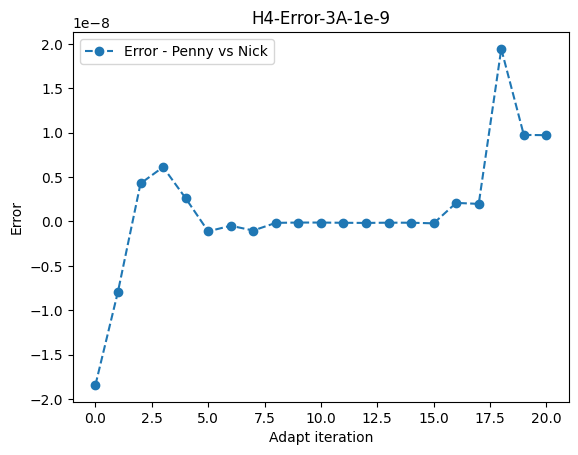

In [10]:
energies_3A_BFGS = np.array([-1.4300836708403173,
  -1.5694603835519534,
  -1.7436334426148354,
  -1.8421101514360743,
  -1.8504359363287717,
  -1.8594600250246844,
  -1.8656767410819342,
  -1.8663879748307888,
  -1.8843560329991837,
  -1.884436165324892,
  -1.88443616708599,
  -1.884436452151924,
  -1.8844364556209934,
  -1.8844365759389552,
  -1.8844365764040125,
  -1.8844612571990726,
  -1.8850966738555366,
  -1.8850974347805467,
  -1.8851248847626085,
  -1.885124894442221,
  -1.8851248944725403])

Nick_3A = np.array([-1.430083652442,  -1.569460375668,   -1.743633446894,  -1.842110157560, 
                   -1.850435938949, -1.859460023915, -1.865676740601, -1.866387973815, 
                    -1.884356032844, -1.884436165205, -1.884436166965, -1.884436452006,
                   -1.884436455459,  -1.884436575804, -1.884436576265, -1.884461256990, 
                   -1.885096675950, -1.885097436761, -1.885124904188, -1.885124904188,
                   -1.885124904188])

error = energies_3A_BFGS - Nick_3A
print(error)
a_it = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)

import matplotlib.pyplot as plt
plt.plot(a_it, error, '--o', label = "Error - Penny vs Nick")
plt.legend()
plt.xlabel('Adapt iteration')
plt.ylabel('Error')
plt.title('H4-Error-3A-1e-9')
plt.savefig("H4_3A_1e-9.png", format= 'png', dpi = 300)
plt.show()


21